In [ ]:
pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 181 kB 90.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import foolbox as fb
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn.functional as F

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    convo = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    layers = [convo]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
dt = 1 # standard ResNET

class CNNBlock2(nn.Module):
    def __init__(self, in_chan, nf, n_layers):
        super(CNNBlock2, self).__init__()

        self.nlayers = n_layers
        self.nf = nf
        self.chans = in_chan

        self.matrices = self.nlayers

        self.conv1 = conv_block(self.chans, self.nf,pool=False)
        self.convs = nn.ModuleList([nn.Conv2d(self.nf, self.nf,3,1,1,bias=True) for i in range(self.matrices)])
        self.convsO = nn.ModuleList([nn.Conv2d(self.nf, self.nf,3,1,1,bias=False) for i in range(self.matrices)])

        self.mp = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.conv1(x)

        count = 0

        #cc = Positive(self.ells)

        for i in np.arange(0,self.matrices):
          A = self.convs[i]
          B = self.convsO[i]
          #x = x + dt * torch.relu(self.bn[i](A(x)))
          x = x + dt * B(torch.relu(((A(x)))))

        x = self.mp(x)
        return x

class Network2(nn.Module):
    def __init__(self, in_chan, nf1, nf2, nf3, n_l1, n_l2, n_l3):
        super(Network2, self).__init__()

        self.input = in_chan
        self.nf1 = nf1
        self.nf2 = nf2
        self.nf3 = nf3
        self.n_l1 = n_l1
        self.n_l2 = n_l2
        self.n_l3 = n_l3

        self.seq = nn.Sequential(
            CNNBlock2(self.input,self.nf1,self.n_l1),
            CNNBlock2(self.nf1,self.nf2,self.n_l2),
            CNNBlock2(self.nf2,self.nf3,self.n_l3),
            nn.Flatten(),
            nn.Linear(2048,10)
          )
 
    def forward(self,x):
      x = self.seq(x)
      return x

In [ ]:
class multiClassHingeLoss(nn.Module):
    def __init__(self, p=1, margin=1, device='cpu', size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.margin=margin
        self.size_average=size_average
        self.device = device
    def forward(self, output, y):
        output_y=output[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)].view(-1,1) #it is a (Batch Size x 1) tensor, having entries that are x[y]
        loss=output-output_y+self.margin #this has self.margin in position y and the difference between the entry of x and x[y] in the other positions
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)]=0 #sets to 0 the entry in position y, instead of having self.margin
        #max(0,_)
        loss[loss<0]=0 #sets to 0 the entries of loss where we have negative numbers, i.e. those meeting the margin (there is a higher difference than the margin between x[y] and x[i])
        #sum up
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]
        return loss

In [ ]:
import torch.optim as optim

marginList = [0.07,0.15,0.3]
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]

robust_accuracy = np.zeros((len(marginList),len(epsilons)))

In [ ]:
class Normalisation(torch.nn.Module):
    def __init__(self, means=(0.4914, 0.4822, 0.4465), stds=(0.247, 0.243, 0.261)):
        super().__init__()
        assert len(means) == len(stds)
        self.means = means
        self.stds = stds
    
    def forward(self, x):
        return (x - torch.tensor(self.means, device=x.device).view(1, len(self.means), 1, 1)) / torch.tensor(self.stds, device=x.device).view(1, len(self.means), 1, 1)

In [ ]:
it = 0

for margin in marginList:

  ResNet = Network2(3,32,64,128,4,4,4)
  ResNet.to(device);

  #criterion = nn.CrossEntropyLoss().to(device)
  criterion = multiClassHingeLoss(margin = margin)
  optimizer = optim.SGD(ResNet.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.2)

  
  EPOCHS = 100
  for epoch in range(EPOCHS):
      losses = []
      running_loss = 0
      for i, inp in enumerate(trainloader):
          inputs, labels = inp
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
      
          outputs = ResNet(inputs)
          #l1_reg = gamma * (net.seq[0].getReg()+net.seq[1].getReg()+net.seq[2].getReg())
          loss = criterion(outputs, labels)#+l1_reg
          losses.append(loss.item())
          loss.backward()

          optimizer.step()
          running_loss += loss.item()
          
          if i%100 == 0 and i > 0:
              print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
              running_loss = 0.0
      #Check current accuracy
      correct = 0
      total = 0
      # since we're not training, we don't need to calculate the gradients for our outputs
      
      ResNet.eval()
      with torch.no_grad():
          for data in testloader:
              images, labels = data
              images.shape
              # calculate outputs by running images through the network
              outputs = ResNet(images.to(device))
              # the class with the highest energy is what we choose as prediction
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels.to(device)).sum().item()
          print('Current accuracy on 10000 test images: %d %%' % (
              100 * correct / total))
          #print(net.seq[1].u.data)
      ResNet.train()
      scheduler.step()
      if epoch%10 == 0 and epoch>0:
          lr=optimizer.param_groups[0]["lr"]
  print('Training Done')

  transform_test_rob = transforms.Compose([
    transforms.ToTensor()
  ])
  batch_size = 1024
  testset_rob = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test_rob)
  testloader_rob = torch.utils.data.DataLoader(testset_rob, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  images, labels = next(iter(testloader_rob))
  images, labels = images.to(device), labels.to(device)
  model = nn.Sequential(Normalisation(),ResNet).eval()
  fmodel = fb.PyTorchModel(model, bounds=(0, 1))
  
  attack = fb.attacks.L2PGD(steps=10)
  
  _, advs, success = attack(fmodel, images, labels, epsilons=epsilons)
  robust_accuracy[it] = torch.mean((1-1.*success),axis=1).detach().cpu().numpy()


  it+=1

Loss [1, 100](epoch, minibatch):  0.42154415100812914
Loss [1, 200](epoch, minibatch):  0.23532724291086196
Loss [1, 300](epoch, minibatch):  0.19808267280459405
Current accuracy on 10000 test images: 61 %
Loss [2, 100](epoch, minibatch):  0.17616442583501338
Loss [2, 200](epoch, minibatch):  0.1647523870319128
Loss [2, 300](epoch, minibatch):  0.15914969205856322
Current accuracy on 10000 test images: 62 %
Loss [3, 100](epoch, minibatch):  0.1457348244637251
Loss [3, 200](epoch, minibatch):  0.1412154509872198
Loss [3, 300](epoch, minibatch):  0.13442299105226993
Current accuracy on 10000 test images: 66 %
Loss [4, 100](epoch, minibatch):  0.12393445871770382
Loss [4, 200](epoch, minibatch):  0.11835490383207797
Loss [4, 300](epoch, minibatch):  0.12360533528029918
Current accuracy on 10000 test images: 71 %
Loss [5, 100](epoch, minibatch):  0.11566948339343071
Loss [5, 200](epoch, minibatch):  0.10736165031790733
Loss [5, 300](epoch, minibatch):  0.10546373829245567
Current accuracy 

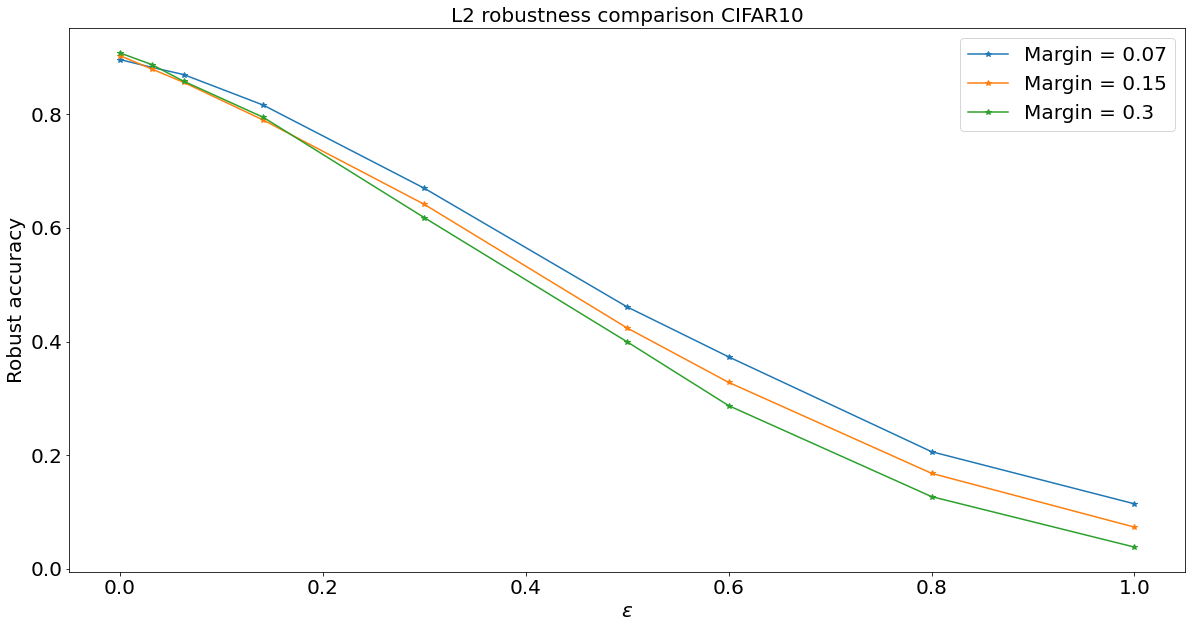

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(len(marginList)):
  plt.plot(epsilons,robust_accuracy[i],'-*',label=f"Margin = {marginList[i]}")
plt.xlabel(r"$\varepsilon$",fontsize=20)
plt.ylabel("Robust accuracy",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc=1)
plt.title(f"L2 robustness comparison CIFAR10",fontsize=20);

In [ ]:
robust_accuracy

array([[0.89648438, 0.8828125 , 0.87011719, 0.81640625, 0.66992188,
        0.4609375 , 0.37304688, 0.20605469, 0.11425781],
       [0.90332031, 0.87988281, 0.85644531, 0.79003906, 0.64160156,
        0.42382812, 0.328125  , 0.16796875, 0.07324219],
       [0.90820312, 0.88769531, 0.85839844, 0.79492188, 0.61816406,
        0.39941406, 0.28710938, 0.12695312, 0.03808594]])

In [ ]:
epsilons = np.array([0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0])
index_keep = [0,2,3,4,5,-1]
epsilons[index_keep]

array([0.        , 0.0627451 , 0.14117647, 0.3       , 0.5       ,
       1.        ])

In [ ]:
import numpy as np
res = np.array([[0.89648438, 0.8828125 , 0.87011719, 0.81640625, 0.66992188,
        0.4609375 , 0.37304688, 0.20605469, 0.11425781],
       [0.90332031, 0.87988281, 0.85644531, 0.79003906, 0.64160156,
        0.42382812, 0.328125  , 0.16796875, 0.07324219],
       [0.90820312, 0.88769531, 0.85839844, 0.79492188, 0.61816406,
        0.39941406, 0.28710938, 0.12695312, 0.03808594]])

In [ ]:
print(" \\\\\n".join([" & ".join(map('{0:.3f}'.format, line)) for line in res[:,index_keep]]))

0.896 & 0.870 & 0.816 & 0.670 & 0.461 & 0.114 \\
0.903 & 0.856 & 0.790 & 0.642 & 0.424 & 0.073 \\
0.908 & 0.858 & 0.795 & 0.618 & 0.399 & 0.038
